In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import pandas as pd
import numpy as np
from plotnine import *
import plotnine
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler
from patsy import dmatrix 
from numpy.linalg import inv
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, Ridge
import matplotlib.pyplot as plt
import matplotlib

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [2]:
happy = pd.read_csv("../data/WHR20_DataForFigure2.1.csv")
new_cols = ['country', 'region', 'happiness_score', 'log_gdp_per_cap', 
           'social_support', 'healthy_life_expectancy', 'freedom_choices', 'generosity',
           'corruption_perception']

happy = happy[['Country name', 'Regional indicator', 'Ladder score',
       'Logged GDP per capita', 'Social support', 'Healthy life expectancy',
       'Freedom to make life choices', 'Generosity',
       'Perceptions of corruption']]
old_cols = happy.columns
happy.columns = new_cols

In [3]:
pops = pd.read_csv("../data/populations.csv")
pops = pops[['Country Name', '2019 [YR2019]']]
pops = pops.dropna()
new = pops[pops["Country Name"].isin(happy.country.values)]
new.columns = ['country', 'population']

In [4]:
unem = pd.read_csv("../data/unemployment.csv")
unem = unem[['Country Name', '2019 [YR2019]']]
unem = unem.dropna()
unem_new = unem[unem["Country Name"].isin(happy.country.values)]
unem_new.columns = ['country', 'unemployment']
unem_new = unem_new[unem_new['unemployment'] != ".."]

In [5]:
inf = pd.read_csv("../data/infants.csv")
inf = inf[['Country Name', '2019 [YR2019]']]
inf = inf.dropna()
new_inf = inf[inf["Country Name"].isin(happy.country.values)]
new_inf.columns = ['country', 'infant_rate']
new_inf = new_inf[new_inf['infant_rate'] != ".."]
#new_inf.head(6)
extra_rows = pd.DataFrame({'country': ['Taiwan Province of China', 'Hong Kong S.A.R. of China',
                                      'Egypt', 'Ivory Coast', 'Macedonia', 'Iran', 'Gambia', 'Yemen',
                                      'South Korea', 'Russia', 'Venezuela', 'Swaziland', 
                                      'Laos', 'Kyrgyzstan', 'North Cyprus', 'Congo (Kinshasa)',
                                      'Congo (Brazzaville)', 'Palestinian Territories', 'Slovakia', 'Kosovo'], 
                             'infant_rate': [3.8, 1.292, 17.3, 
                                            58.6, 5.3, 12, 35.9, 43.6,
                                           2.7, 4.9, 21, 38.6, 36.4, 16.4, 
                                           1.8, 66.1, 34.9, 16.6, 4.7, 12]})
new_inf = new_inf.append(pd.DataFrame(data = extra_rows), ignore_index = True)
happy[~happy["country"].isin(new_inf.country.values)]
new_inf[new_inf['infant_rate'] == ".."]

,country,region,happiness_score,log_gdp_per_cap,social_support,healthy_life_expectancy,freedom_choices,generosity,corruption_perception


,country,infant_rate


In [6]:
extra_rows = pd.DataFrame({'country': ['Taiwan Province of China', 'Hong Kong S.A.R. of China',
                                      'Egypt', 'Ivory Coast', 'Macedonia', 'Iran', 'Gambia', 'Yemen',
                                      'South Korea', 'Russia', 'Venezuela', 'Swaziland', 
                                      'Laos', 'Kyrgyzstan', 'North Cyprus', 'Congo (Kinshasa)',
                                      'Congo (Brazzaville)', 'Palestinian Territories', 'Slovakia', 'Kosovo'], 
                             'unemployment': [3.71, 2.96000003814697, 9.72999954223633, 3.17000007629395, 
                                            17.2600002288818, 11.1400003433228, 8.9399995803833, 12.8999996185303, 3.75,
                                           4.59999990463257, 7.15999984741211, 20.08, .63, 6.71999979019165, 7.07000017166138, 
                                           4.13000011444092, 9.60000038146973, 25, 5.75, 24.50]})
unem_new = unem_new.append(pd.DataFrame(data = extra_rows), ignore_index = True)
happy[~happy["country"].isin(unem_new.country.values)]
unem_new = unem_new.dropna()

,country,region,happiness_score,log_gdp_per_cap,social_support,healthy_life_expectancy,freedom_choices,generosity,corruption_perception


In [7]:
extra_rows = pd.DataFrame({'country': ['Taiwan Province of China', 'Hong Kong S.A.R. of China',
                                      'Egypt', 'Ivory Coast', 'Macedonia', 'Iran', 'Gambia', 'Yemen',
                                      'South Korea', 'Russia', 'Venezuela', 'Swaziland', 
                                      'Laos', 'Kyrgyzstan', 'North Cyprus', 'Congo (Kinshasa)',
                                      'Congo (Brazzaville)', 'Palestinian Territories', 'Slovakia'], 
                             'population': [23773876, 7507000, 100388073, 25716544, 
                                            2077000, 82913906, 2347706, 29161922, 51709098,
                                           144373535, 28515829, 1148000, 7169000, 6456900, 1198575, 
                                           86790567, 5380508, 4685000, 5454073]})
new = new.append(pd.DataFrame(data = extra_rows), ignore_index = True)

In [8]:
happy = happy.merge(new, on='country', how='left')
happy = happy.merge(unem_new, on = 'country', how = 'left')
happy = happy.merge(new_inf, on = 'country', how = 'left')

In [10]:
happy = happy.astype({'population': 'float64'})
happy = happy.astype({'unemployment': 'float64'})
happy = happy.astype({'infant_rate': 'float64'})
happy.info()
happy.head(5)
happy.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 153 entries, 0 to 152
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   country                  153 non-null    object 
 1   region                   153 non-null    object 
 2   happiness_score          153 non-null    float64
 3   log_gdp_per_cap          153 non-null    float64
 4   social_support           153 non-null    float64
 5   healthy_life_expectancy  153 non-null    float64
 6   freedom_choices          153 non-null    float64
 7   generosity               153 non-null    float64
 8   corruption_perception    153 non-null    float64
 9   population               153 non-null    float64
 10  unemployment             153 non-null    float64
 11  infant_rate              153 non-null    float64
dtypes: float64(10), object(2)
memory usage: 15.5+ KB


,country,region,happiness_score,log_gdp_per_cap,social_support,healthy_life_expectancy,freedom_choices,generosity,corruption_perception,population,unemployment,infant_rate
0,Finland,Western Europe,7.8087,10.639267,0.954330,71.900825,0.949172,-0.059482,0.195445,5520314.0,6.70,1.9
1,Denmark,Western Europe,7.6456,10.774001,0.955991,72.402504,0.951444,0.066202,0.168489,5818553.0,5.02,3.2
2,Switzerland,Western Europe,7.5599,10.979933,0.942847,74.102448,0.921337,0.105911,0.303728,8574832.0,4.39,3.6
3,Iceland,Western Europe,7.5045,10.772559,0.974670,73.000000,0.948892,0.246944,0.711710,361313.0,3.51,1.6
4,Norway,Western Europe,7.4880,11.087804,0.952487,73.200783,0.955750,0.134533,0.263218,5347896.0,3.69,2.0


,happiness_score,log_gdp_per_cap,social_support,healthy_life_expectancy,freedom_choices,generosity,corruption_perception,population,unemployment,infant_rate
count,153.00000,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,1.530000e+02,153.000000,153.000000
mean,5.47324,9.295706,0.808721,64.445529,0.783360,-0.014568,0.733120,4.896478e+07,6.967255,20.176418
std,1.11227,1.201588,0.121453,7.057848,0.117786,0.151809,0.175172,1.620566e+08,5.410351,19.893916
min,2.56690,6.492642,0.319460,45.200001,0.396573,-0.300907,0.109784,3.613130e+05,0.130000,1.292000
25%,4.72410,8.350645,0.737217,58.961712,0.714839,-0.127015,0.683019,4.937374e+06,3.480000,4.200000
50%,5.51500,9.456313,0.829204,66.305145,0.799805,-0.033665,0.783122,1.126308e+07,5.100000,12.200000
75%,6.22850,10.265124,0.906747,69.289192,0.877709,0.085429,0.849151,3.647177e+07,9.010000,32.300000
max,7.80870,11.450681,0.974670,76.804581,0.974998,0.560664,0.935585,1.397715e+09,28.469999,81.000000


In [10]:
happy_corr = happy.corr()
happy_corr

,happiness_score,log_gdp_per_cap,social_support,healthy_life_expectancy,freedom_choices,generosity,corruption_perception,population,unemployment,infant_rate
happiness_score,1.000000,0.775374,0.765001,0.770316,0.590597,0.069043,-0.418305,-0.106096,-0.225478,-0.686001
log_gdp_per_cap,0.775374,1.000000,0.781814,0.848469,0.419019,-0.118399,-0.334729,-0.001029,0.000143,-0.834524
social_support,0.765001,0.781814,1.000000,0.742744,0.478863,-0.056780,-0.210530,-0.104798,-0.017686,-0.738979
healthy_life_expectancy,0.770316,0.848469,0.742744,1.000000,0.448846,-0.071852,-0.353841,-0.009082,-0.110446,-0.925256
freedom_choices,0.590597,0.419019,0.478863,0.448846,1.000000,0.253721,-0.420145,0.110220,-0.365523,-0.401293
generosity,0.069043,-0.118399,-0.056780,-0.071852,0.253721,1.000000,-0.278480,0.006832,-0.321006,0.146606
corruption_perception,-0.418305,-0.334729,-0.210530,-0.353841,-0.420145,-0.278480,1.000000,0.038426,0.221722,0.236842
population,-0.106096,-0.001029,-0.104798,-0.009082,0.110220,0.006832,0.038426,1.000000,-0.078638,0.005310
unemployment,-0.225478,0.000143,-0.017686,-0.110446,-0.365523,-0.321006,0.221722,-0.078638,1.000000,0.007897
infant_rate,-0.686001,-0.834524,-0.738979,-0.925256,-0.401293,0.146606,0.236842,0.005310,0.007897,1.000000


<Figure size 1152x432 with 0 Axes>

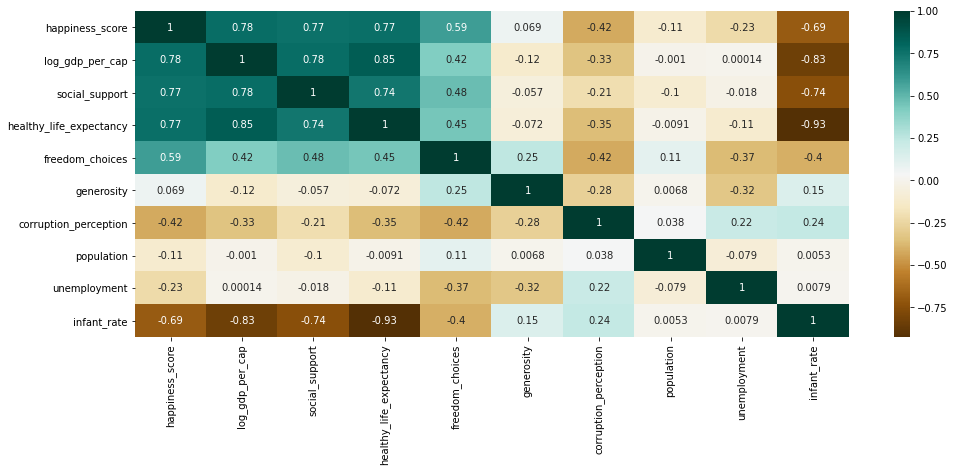

In [11]:
plt.figure(figsize=(16, 6))
sns.heatmap(happy_corr, annot=True, cmap='BrBG')

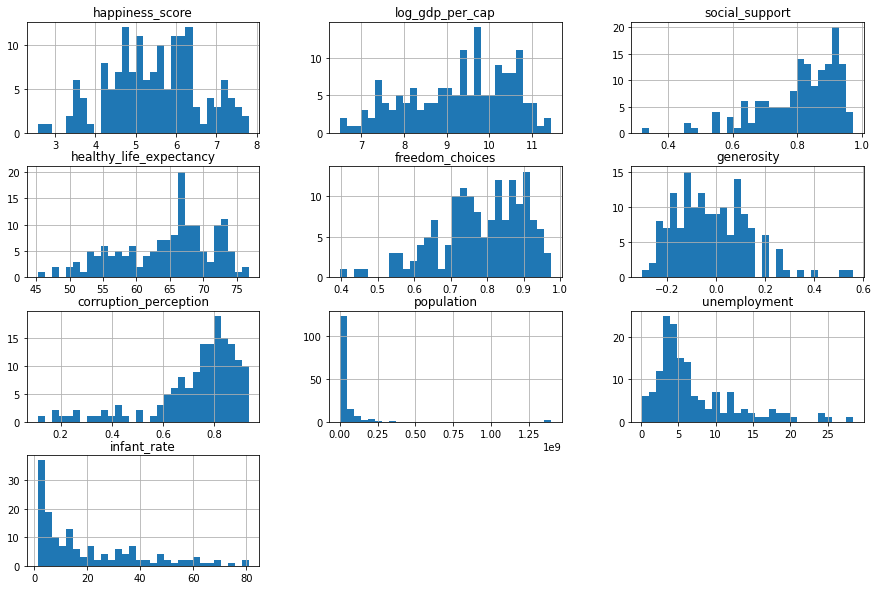

In [12]:
happy.hist(figsize=(15,10),bins=30);

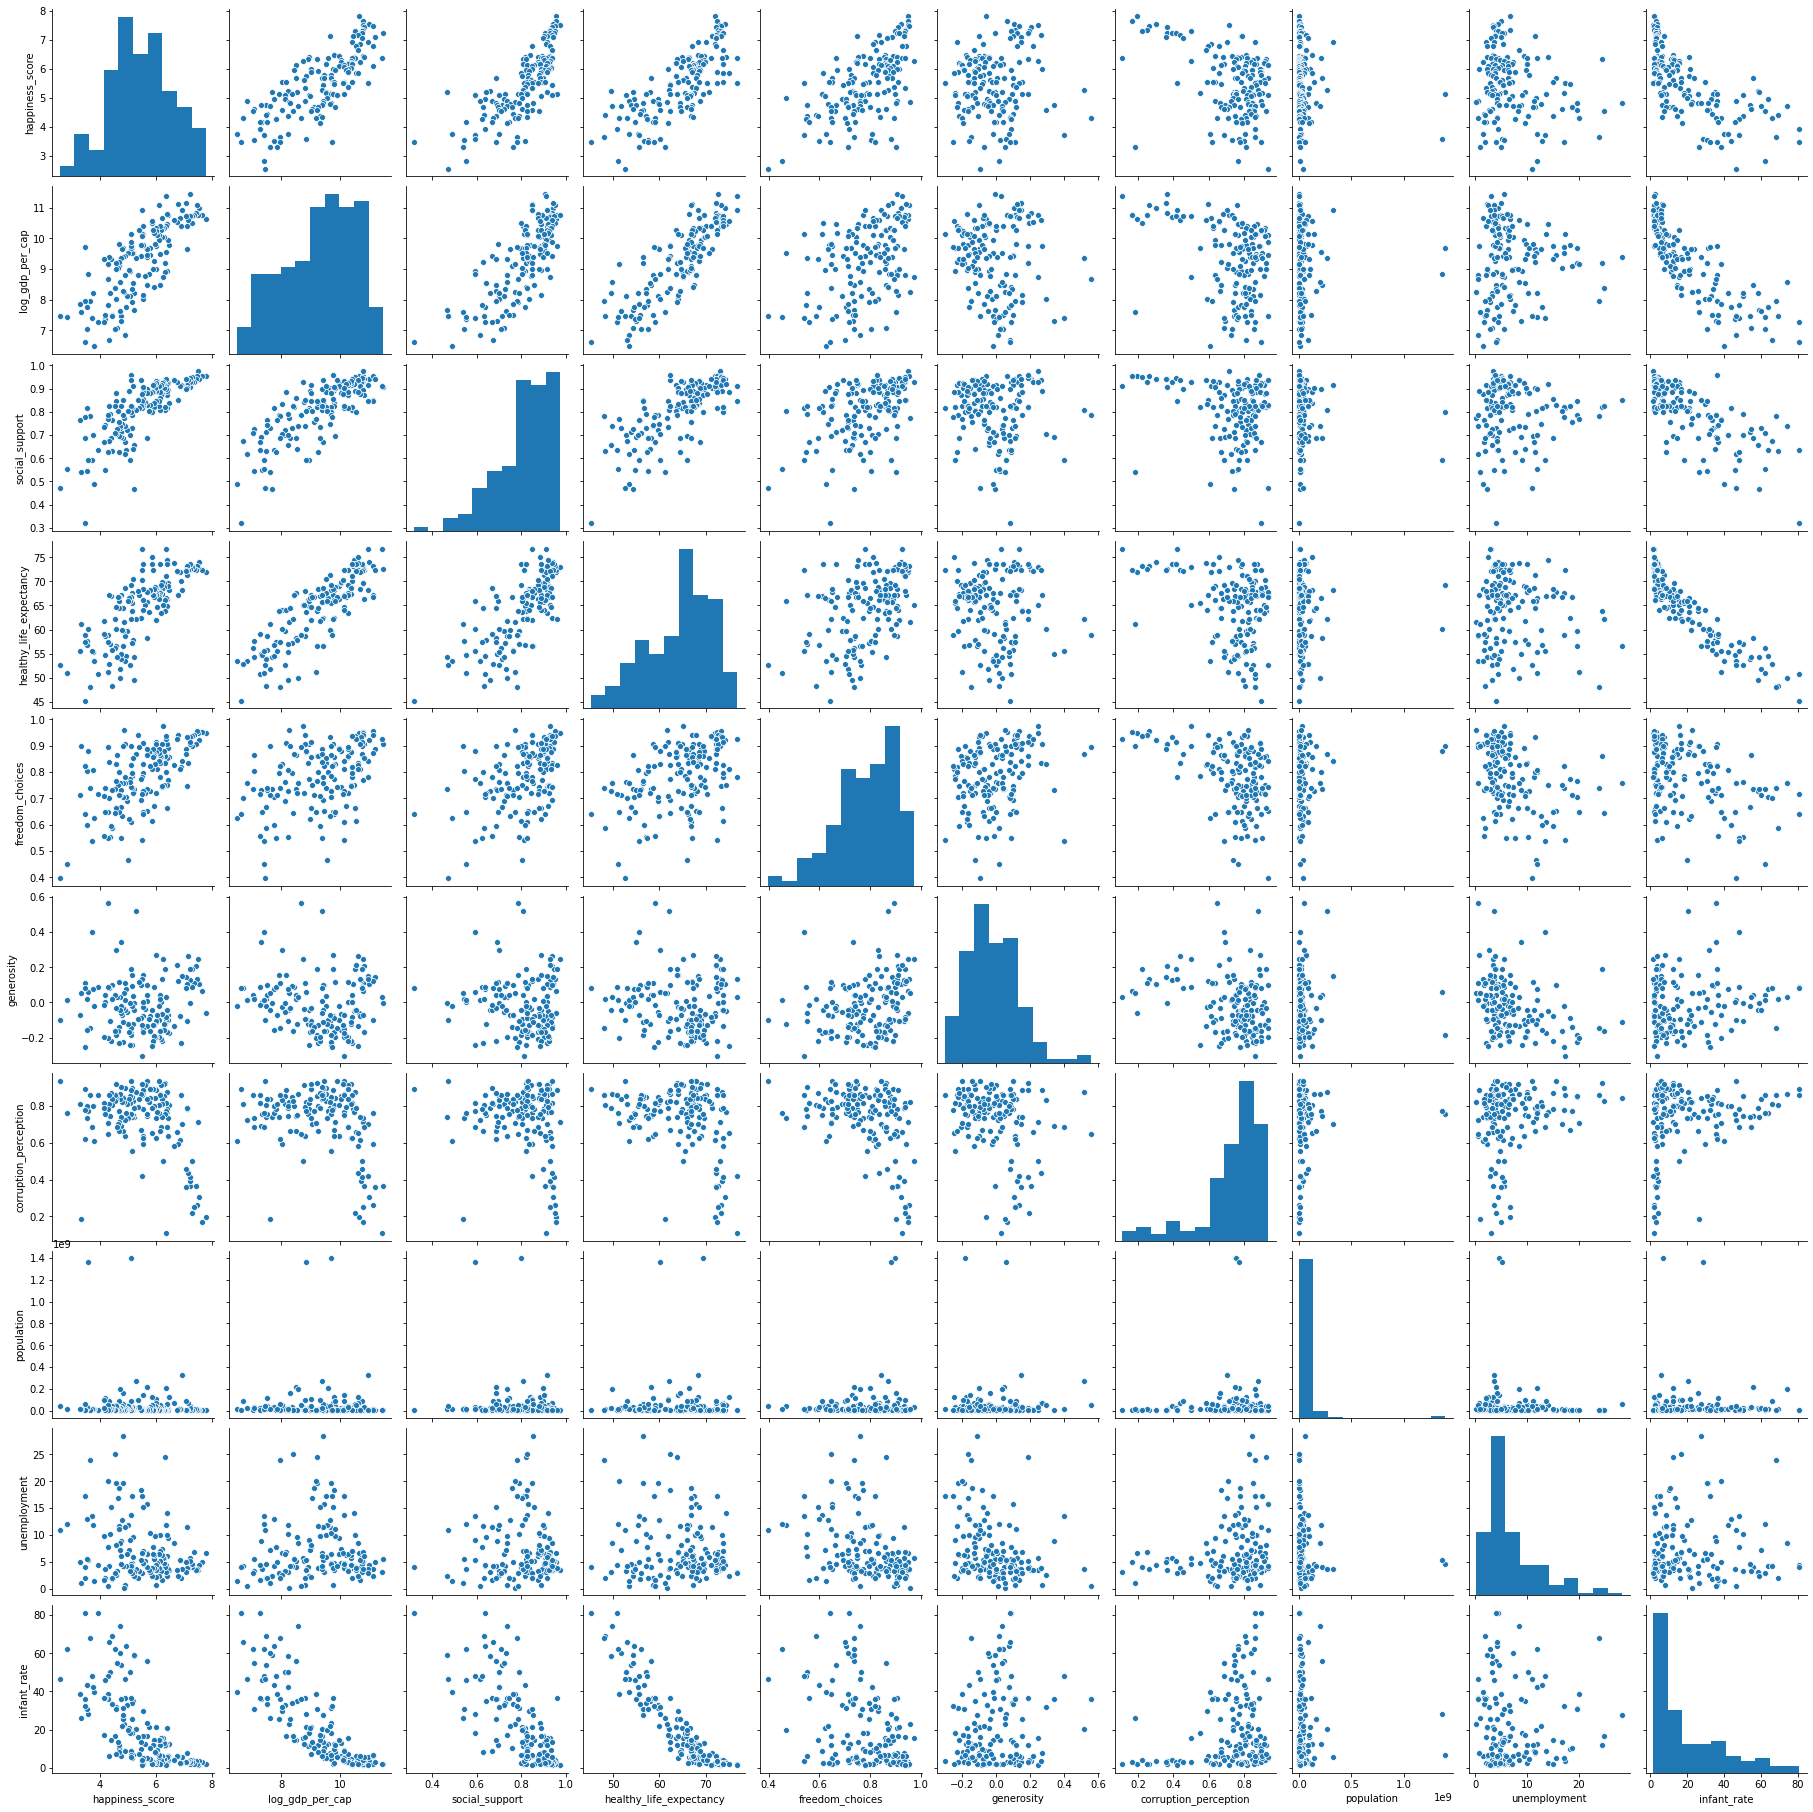

In [13]:
sns.pairplot(happy);

In [14]:
happy_df = happy.drop(['country', 'region'], axis = 1)
x = happy_df.copy()
y = x.pop('happiness_score')
x

,log_gdp_per_cap,social_support,healthy_life_expectancy,freedom_choices,generosity,corruption_perception,population,unemployment,infant_rate
0,10.639267,0.954330,71.900825,0.949172,-0.059482,0.195445,5520314.0,6.70,1.9
1,10.774001,0.955991,72.402504,0.951444,0.066202,0.168489,5818553.0,5.02,3.2
2,10.979933,0.942847,74.102448,0.921337,0.105911,0.303728,8574832.0,4.39,3.6
3,10.772559,0.974670,73.000000,0.948892,0.246944,0.711710,361313.0,3.51,1.6
4,11.087804,0.952487,73.200783,0.955750,0.134533,0.263218,5347896.0,3.69,2.0
...,...,...,...,...,...,...,...,...,...
148,6.625160,0.319460,45.200001,0.640881,0.082410,0.891807,4745185.0,4.04,81.0
149,7.600104,0.540835,61.098846,0.900589,0.055484,0.183541,12626950.0,0.99,26.3
150,7.865712,0.763093,55.617260,0.711458,-0.072064,0.810237,14645468.0,5.02,38.4
151,7.425360,0.553707,51.000000,0.451314,0.016519,0.763417,11062113.0,12.01,62.4


In [15]:
with_dummy = pd.get_dummies(happy, columns=["region"])

In [16]:
di = {} 
list1 = list(range(0,10))
for key in happy.region.unique(): 
    for value in list1: 
        di[key] = value 
        list1.remove(value)
        break 

In [17]:
scaler = StandardScaler()
x_scaled = scaler.fit(x)
x_scaled = scaler.transform(x)
scaled_x = pd.DataFrame(x_scaled)
scaled_x.columns = ['log_gdp_per_cap', 'social_support', 'healthy_life_expectancy', 'freedom_choices', 
                       'generosity', 'corruption_perception', 'population', 'unemployment', 'infant_rate']
scaled_x = pd.concat([scaled_x.reset_index(drop=True), 
                       with_dummy[['region_Central and Eastern Europe',
                                 'region_Commonwealth of Independent States', 'region_East Asia',
                                 'region_Latin America and Caribbean',
                                 'region_Middle East and North Africa', 'region_North America and ANZ',
                                 'region_South Asia', 'region_Southeast Asia',
                                 'region_Sub-Saharan Africa', 'region_Western Europe']]], axis=1)
scaled_x

,log_gdp_per_cap,social_support,healthy_life_expectancy,freedom_choices,generosity,corruption_perception,population,unemployment,infant_rate,region_Central and Eastern Europe,region_Commonwealth of Independent States,region_East Asia,region_Latin America and Caribbean,region_Middle East and North Africa,region_North America and ANZ,region_South Asia,region_Southeast Asia,region_Sub-Saharan Africa,region_Western Europe
0,1.121827,1.202824,1.059782,1.412360,-0.296829,-3.079488,-0.268962,-0.049559,-0.921711,0,0,0,0,0,0,0,0,0,1
1,1.234325,1.216545,1.131096,1.431713,0.533799,-3.233871,-0.267116,-0.361095,-0.856150,0,0,0,0,0,0,0,0,0,1
2,1.406271,1.107965,1.372746,1.175261,0.796232,-2.459302,-0.250052,-0.477921,-0.835977,0,0,0,0,0,0,0,0,0,1
3,1.233121,1.370844,1.216031,1.409972,1.728302,-0.122627,-0.300902,-0.641106,-0.936840,0,0,0,0,0,0,0,0,0,1
4,1.496340,1.187598,1.244573,1.468391,0.985388,-2.691321,-0.270030,-0.607727,-0.916668,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,-2.229813,-4.041620,-2.735782,-1.213617,0.640919,0.908862,-0.273761,-0.542824,3.067437,0,0,0,0,0,0,0,0,1,0
149,-1.415768,-2.212912,-0.475736,0.998540,0.462966,-3.147664,-0.224966,-1.108409,0.308823,0,0,0,0,0,0,0,0,1,0
150,-1.193995,-0.376920,-1.254952,-0.612452,-0.379981,0.441679,-0.212469,-0.361095,0.919046,0,0,0,0,0,0,0,0,1,0
151,-1.561674,-2.106583,-1.911303,-2.828318,0.205449,0.173524,-0.234653,0.935116,2.129407,0,0,0,0,0,0,0,0,1,0


In [18]:
train_x, test_x, train_y, test_y = train_test_split(scaled_x, y, test_size = .3, random_state = 13)

train_x.shape
train_y.shape
test_x.shape
test_y.shape

(107, 19)

(107,)

(46, 19)

(46,)

# Modeling

## Linear

In [19]:
ln = LinearRegression()
fit = ln.fit(train_x, train_y)

In [20]:
from sklearn import metrics
preds = fit.predict(train_x)
test_preds = fit.predict(test_x)
print('R2 Value: ', ln.score(train_x, train_y))
print('training MSE: ', metrics.mean_squared_error(train_y, preds))
print('test MSE: ', metrics.mean_squared_error(test_y, test_preds))
linear_error = metrics.mean_squared_error(test_y, test_preds)

R2 Value:  0.8325785700411612
training MSE:  0.20278806628923365
test MSE:  0.2850704477000151


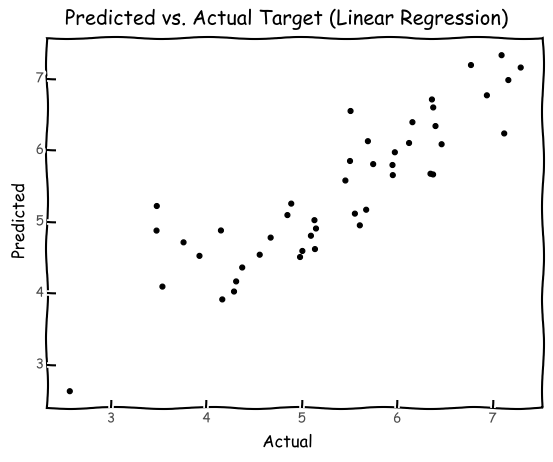

<ggplot: (8751347122327)>

In [21]:
df_lin = pd.DataFrame({'Actual': test_y.values, 
              'Predicted': test_preds})

(
ggplot() +
    geom_point(data = df_lin, mapping = aes(x = 'Actual', y = 'Predicted')) +
    theme_xkcd() +
    labs(title = "Predicted vs. Actual Target (Linear Regression)") 
)

## Ridge

In [22]:
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
ridge = Ridge()
# define model evaluation method
cv = RepeatedKFold(n_splits = 10, n_repeats=3, random_state=13)
# define grid
grid = dict()
grid['alpha'] = np.arange(0, 1, 0.01)
search = GridSearchCV(ridge, grid, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
results = search.fit(train_x, train_y)
# summarize
print('MAE: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

MAE: -0.317
Config: {'alpha': 0.99}


In [23]:
ridgereg = Ridge(alpha = .99)
ridgereg.fit(train_x, train_y)
preds = ridgereg.predict(train_x)
test_preds = ridgereg.predict(test_x)
print('R2 Value: ', ridgereg.score(train_x, train_y))
print('training MSE: ', metrics.mean_squared_error(train_y, preds))
print('test MSE: ', metrics.mean_squared_error(test_y, test_preds))
ridge_error = metrics.mean_squared_error(test_y, test_preds)

Ridge(alpha=0.99)

R2 Value:  0.8309497499665225
training MSE:  0.20476096350645537
test MSE:  0.29114498743354617


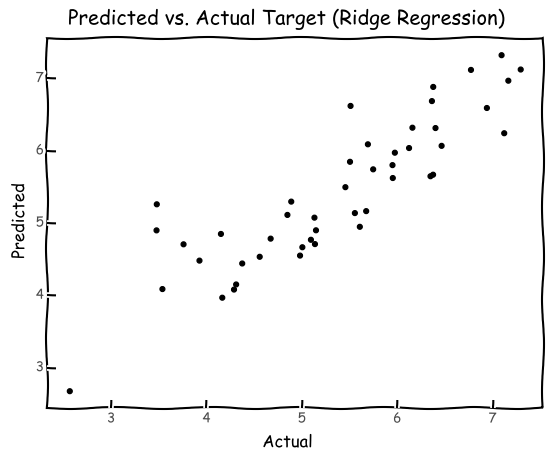

<ggplot: (8751356581084)>

In [24]:
df_ridge = pd.DataFrame({'Actual': test_y.values, 
              'Predicted': test_preds})

(
ggplot() +
    geom_point(data = df_ridge, mapping = aes(x = 'Actual', y = 'Predicted')) +
    theme_xkcd() +
    labs(title = "Predicted vs. Actual Target (Ridge Regression)") 
)

## Lasso

In [25]:
lasso = Lasso()
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=13)
# define grid
grid = dict()
grid['alpha'] = np.arange(0, 1, 0.01)
search = GridSearchCV(lasso, grid, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
results = search.fit(train_x, train_y)
# summarize
print('MAE: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

MAE: -0.329
Config: {'alpha': 0.0}


/home/abe/.local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:765: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/home/abe/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
/home/abe/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.849161546473987, tolerance: 0.012960302094112218


In [41]:
lassoreg = Lasso(alpha = .01, random_state = 13)
lassoreg.fit(train_x, train_y)
preds = lassoreg.predict(train_x)
test_preds = lassoreg.predict(test_x)
print('R2 Value: ', lassoreg.score(train_x, train_y))
print('training MSE: ', metrics.mean_squared_error(train_y, preds))
print('test MSE: ', metrics.mean_squared_error(test_y, test_preds))
lasso_error = metrics.mean_squared_error(test_y, test_preds)

Lasso(alpha=0.01, random_state=13)

R2 Value:  0.8090315643620533
training MSE:  0.23130921647736594
test MSE:  0.30797253446769063


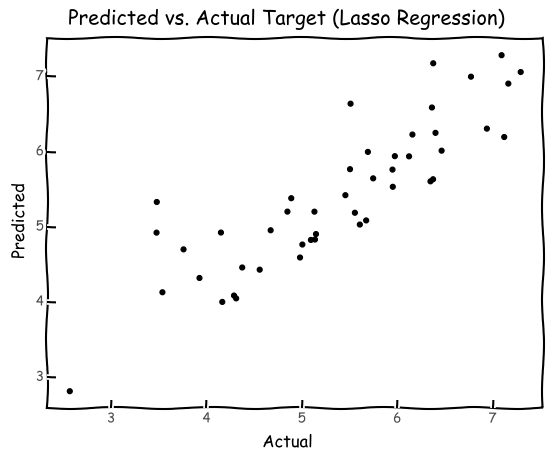

<ggplot: (8751356544088)>

In [27]:
df_lasso = pd.DataFrame({'Actual': test_y.values, 
              'Predicted': test_preds})

(
ggplot() +
    geom_point(data = df_lasso, mapping = aes(x = 'Actual', y = 'Predicted')) +
    theme_xkcd() +
    labs(title = "Predicted vs. Actual Target (Lasso Regression)") 
)

## Random Forrest 

In [28]:
n_estimators = [int(x) for x in np.linspace(start = 300, stop = 1000, num = 8)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
random_grid

{'n_estimators': [300, 400, 500, 600, 700, 800, 900, 1000],
 'max_features': ['auto', 'sqrt'],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4]}

In [29]:
scaler = StandardScaler()
x_scaled = scaler.fit(x)
x_scaled = scaler.transform(x)
scaled_x_rf = pd.DataFrame(x_scaled)
scaled_x_rf.columns = ['log_gdp_per_cap', 'social_support', 'healthy_life_expectancy', 'freedom_choices', 
                       'generosity', 'corruption_perception', 'population', 'unemployment', 'infant_rate']
scaled_x_rf['region'] = happy['region']
scaled_x_rf = scaled_x_rf.replace({'region': di})
scaled_x_rf

,log_gdp_per_cap,social_support,healthy_life_expectancy,freedom_choices,generosity,corruption_perception,population,unemployment,infant_rate,region
0,1.121827,1.202824,1.059782,1.412360,-0.296829,-3.079488,-0.268962,-0.049559,-0.921711,0
1,1.234325,1.216545,1.131096,1.431713,0.533799,-3.233871,-0.267116,-0.361095,-0.856150,0
2,1.406271,1.107965,1.372746,1.175261,0.796232,-2.459302,-0.250052,-0.477921,-0.835977,0
3,1.233121,1.370844,1.216031,1.409972,1.728302,-0.122627,-0.300902,-0.641106,-0.936840,0
4,1.496340,1.187598,1.244573,1.468391,0.985388,-2.691321,-0.270030,-0.607727,-0.916668,0
...,...,...,...,...,...,...,...,...,...,...
148,-2.229813,-4.041620,-2.735782,-1.213617,0.640919,0.908862,-0.273761,-0.542824,3.067437,8
149,-1.415768,-2.212912,-0.475736,0.998540,0.462966,-3.147664,-0.224966,-1.108409,0.308823,8
150,-1.193995,-0.376920,-1.254952,-0.612452,-0.379981,0.441679,-0.212469,-0.361095,0.919046,8
151,-1.561674,-2.106583,-1.911303,-2.828318,0.205449,0.173524,-0.234653,0.935116,2.129407,8


In [30]:
train_x, test_x, train_y, test_y = train_test_split(scaled_x_rf, y, test_size = .3, random_state = 13)

train_x.shape
train_y.shape
test_x.shape
test_y.shape

(107, 10)

(107,)

(46, 10)

(46,)

In [31]:
rf = RandomForestRegressor()
cv_search = GridSearchCV(estimator = rf, 
                         param_grid = random_grid, cv = 3, n_jobs = -1, verbose = 2)
cv_search.fit(train_x, train_y)

cv_search.best_estimator_

Fitting 3 folds for each of 1584 candidates, totalling 4752 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 150 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 353 tasks      | elapsed:   37.3s
[Parallel(n_jobs=-1)]: Done 636 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1001 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1446 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 1973 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 2580 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 3269 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 4038 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 4752 out of 4752 | elapsed:  8.7min finished


GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100,
                                       None],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [300, 400, 500, 600, 700, 800, 900,
                                          1000]},
             verbose=2)

RandomForestRegressor(max_depth=50, max_features='sqrt', n_estimators=300)

In [32]:
#rf_one = RandomForestRegressor()
#cv_search_one = GridSearchCV(estimator = rf, 
#                         param_grid = random_grid, cv = 3, n_jobs = -1, verbose = 2)
#cv_search_one.fit(scaled_x, y)

#cv_search_one.best_estimator_

In [33]:
#best_rf_model_one = cv_search_one.best_estimator_
#preds_one = best_rf_model_one.predict(train_x)
#test_preds_one = best_rf_model_one.predict(test_x)
#print('training MSE: ', metrics.mean_squared_error(train_y, preds_one))
#print('test MSE: ', metrics.mean_squared_error(test_y, test_preds_one))
#rf_error_one = metrics.mean_squared_error(test_y, test_preds_one)

In [34]:
cv_search.best_params_

{'max_depth': 50,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 300}

In [35]:
best_rf_model = cv_search.best_estimator_
preds = best_rf_model.predict(train_x)
test_preds = best_rf_model.predict(test_x)
print('training MSE: ', metrics.mean_squared_error(train_y, preds))
print('test MSE: ', metrics.mean_squared_error(test_y, test_preds))
rf_error = metrics.mean_squared_error(test_y, test_preds)

training MSE:  0.03608693185180083
test MSE:  0.3003757526382706


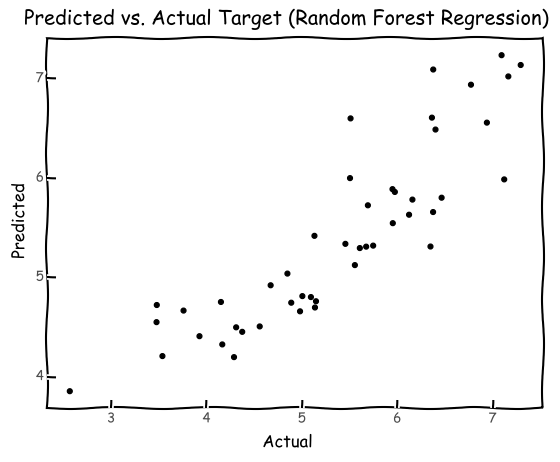

<ggplot: (8751356342881)>

In [36]:
df_rf = pd.DataFrame({'Actual': test_y.values, 
              'Predicted': test_preds})

(
ggplot() +
    geom_point(data = df_rf, mapping = aes(x = 'Actual', y = 'Predicted')) +
    theme_xkcd() +
    labs(title = "Predicted vs. Actual Target (Random Forest Regression)") 
)

# Comparing Models

In [37]:
df_compare = pd.DataFrame({'model': ['Linear', 'Ridge', 'Lasso', 'Random Forest'], 
              'MSE': [linear_error, ridge_error, lasso_error, rf_error] })

df_compare

,model,MSE
0,Linear,0.285070
1,Ridge,0.291145
2,Lasso,0.317703
3,Random Forest,0.300376


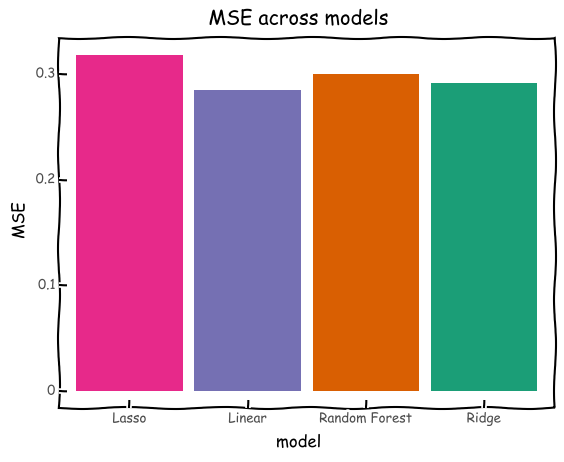

<ggplot: (8751356279257)>

In [38]:
(
ggplot() +
    geom_col(data = df_compare, mapping = aes(x = 'model', y = 'MSE', fill = 'model')) +
    theme_xkcd() +
    labs(title = "MSE across models")  + 
    scale_fill_brewer(type="qual", palette="Dark2", guide = False, direction = -1)
)

## Best Model

/home/abe/.local/lib/python3.8/site-packages/mizani/palettes.py:397: UserWarning: Warning message:Brewer palette Dark2 has a maximum of 8 colors Returning the palette you asked for with that many colors


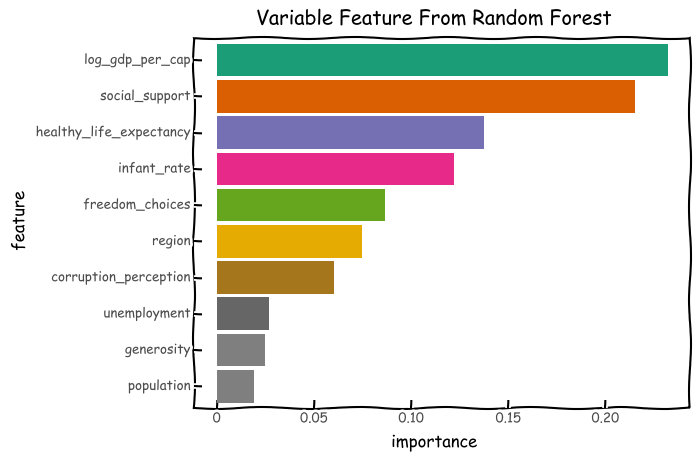

<ggplot: (8751356511058)>

In [39]:
features = scaled_x_rf.columns
importances = best_rf_model.feature_importances_
indices = np.argsort(importances)
df_rf_import = pd.DataFrame({'feature': features, 
              'importance': importances})

df_rf_import = df_rf_import.sort_values(by=['importance']).reset_index(drop = True)
df_rf_import['feature'] = pd.Categorical(df_rf_import.feature, categories = pd.unique(df_rf_import.feature))

(
ggplot() +
    geom_col(data = df_rf_import, mapping = aes(x = 'feature', y = 'importance', fill = 'feature')) +
    theme_xkcd() +
    labs(title = "Variable Feature From Random Forest") +
    coord_flip() + 
    scale_fill_brewer(type="qual", palette="Dark2", guide = False, direction = -1)
)